## **Implementation of Decision Tree Algorithm on Income Classification Dataset**

In [55]:
#import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [56]:
#load dataset
df = pd.read_csv('/content/income_classification.csv')
df.head(10)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K
5,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States,<=50K
6,Private,10th,Separated,Adm-clerical,Unmarried,White,Male,United-States,<=50K
7,State-gov,Doctorate,Never-married,Prof-specialty,Other-relative,White,Female,United-States,>50K
8,Federal-gov,HS-grad,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
9,Private,Some-college,Never-married,Craft-repair,Unmarried,White,Male,?,>50K


# Data Preprocessing

## **1. Data inspection and cleaning**

##### **1.1. Identifying and handling Missing Values **

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       32561 non-null  object
 1   education       32561 non-null  object
 2   marital.status  32561 non-null  object
 3   occupation      32561 non-null  object
 4   relationship    32561 non-null  object
 5   race            32561 non-null  object
 6   sex             32561 non-null  object
 7   native.country  32561 non-null  object
 8   income          32561 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB


Their is a non standard missing values which treated as a object.

In [58]:
df.replace('?', np.nan, inplace=True)

In [59]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 workclass         1836
education            0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
native.country     583
income               0
dtype: int64


In [60]:
df.columns

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')

In [61]:
# Identify columns
num_cols = ['income']
cat_cols =['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country']

In [62]:
#Handle Categorical data
# Impute missing values
cat_imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [63]:
df.isnull().sum()

,0
workclass,0
education,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0
native.country,0
income,0


##### **1.2. Checking Data Types of Columns in the Dataset **

In [64]:
# Check data types for all columns
print("\n" + "="*40)
print("Data Types of All Columns:")
print("="*40)
print(df.dtypes)


Data Types of All Columns:
workclass         object
education         object
marital.status    object
occupation        object
relationship      object
race              object
sex               object
native.country    object
income            object
dtype: object


##### **1.3. Identifying and handling Outliers **


In [65]:
df.describe()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,24532,10501,14976,5983,13193,27816,21790,29753,24720


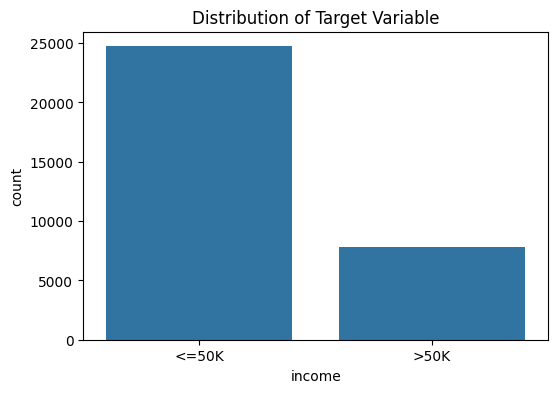

In [66]:
#Check the Distribution of Target (y)
plt.figure(figsize=(6,4))
sns.countplot(x=df['income'])
plt.title("Distribution of Target Variable")
plt.show()

##### **1.4. Identifying and handling duplicate Values **

In [67]:
# Check for duplicate rows
duplicate_rows = df.duplicated()
print("Total Duplicate Rows:", duplicate_rows.sum())

Total Duplicate Rows: 23374


There is need for treating duplicate as these are categorical colums.

In [68]:
print(df.shape)
print(df.isnull().sum())

(32561, 9)
workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
native.country    0
income            0
dtype: int64


## **2. Identifying and Encoding Categorical Features**

In [69]:
# Define order for ordinal variables
ordinal_mapping = [
    ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college',
     'Associate', 'Bachelor', 'Master', 'Doctorate'],  # Education order
    ['Never-married', 'Separated', 'Divorced', 'Widowed', 'Married-AF-spouse', 'Married-civ-spouse']  # Marital status order
]


# Apply ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=ordinal_mapping, handle_unknown='use_encoded_value', unknown_value=-1)

# Encode the columns
df[['education', 'marital.status']] = ordinal_encoder.fit_transform(df[['education', 'marital.status']])

In [70]:
# Apply one-hot encoding to nominal variables
nominal_columns = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'native.country']
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

# Convert 'income' column to binary (0 = '<=50K', 1 = '>50K')
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

In [71]:
df.isnull().sum()

,0
education,0
marital.status,0
income,0
workclass_Local-gov,0
workclass_Never-worked,0
...,...
native.country_Thailand,0
native.country_Trinadad&Tobago,0
native.country_United-States,0
native.country_Vietnam,0


In [72]:
df.reset_index(drop=True, inplace=True)
df.shape

(32561, 73)

## **3. Data Normalization**

In [73]:
# cols_to_scale = []
# scaler = StandardScaler()
# df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
# For Decision Trees? Not needed!

In [74]:
# #Split data
X= df.drop('income', axis=1)
y=df['income']

In [75]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, Y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the DecisionTreeClassifier
DTree = DecisionTreeClassifier(random_state=42)
DTree.fit(X_train, y_train)

# Predictions
y_pred =DTree.predict(X_test)

In [76]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8173


In [77]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      4945
           1       0.64      0.55      0.59      1568

    accuracy                           0.82      6513
   macro avg       0.75      0.73      0.74      6513
weighted avg       0.81      0.82      0.81      6513



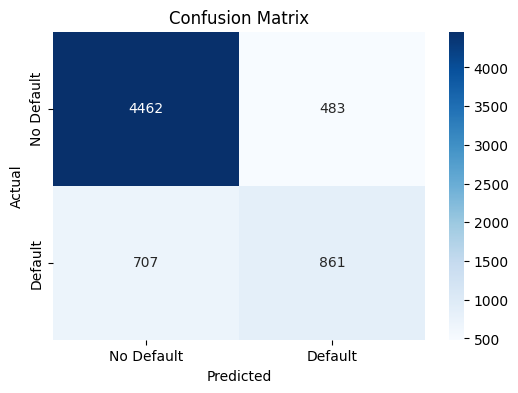

In [78]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()